In [1]:
import tensorflow as tf
import pathlib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
country_images_root = pathlib.Path("/home/pascal_steiger/Downloads/data15/")

In [4]:
def load_image_paths(container_path):
    image_dir = pathlib.Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    image_paths = []
    flat_data = []
    target = []
    count = 0
    train_img_path = []
    train_label = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            count += 1
            train_img_path.append(str(file))
            train_label.append(categories[i])

    X = np.array(train_img_path)
    y = np.array(train_label)
    catStringArr = np.array(categories)

    return X, y, catStringArr

In [5]:
X = []
y = []
X, y, labelStringArr = load_image_paths("/home/pascal_steiger/Downloads/data15/")
img_df = pd.DataFrame(zip(X, y), columns=["path", "label"])

img_df.sample(n=10)

,path,label
14757,/home/pascal_steiger/Downloads/data15/SWE/img_...,SWE
4246,/home/pascal_steiger/Downloads/data15/GBR/img_...,GBR
11086,/home/pascal_steiger/Downloads/data15/POL/img_...,POL
6529,/home/pascal_steiger/Downloads/data15/FIN/img_...,FIN
4627,/home/pascal_steiger/Downloads/data15/GBR/img_...,GBR
5962,/home/pascal_steiger/Downloads/data15/AUT/img_...,AUT
4332,/home/pascal_steiger/Downloads/data15/GBR/img_...,GBR
4256,/home/pascal_steiger/Downloads/data15/GBR/img_...,GBR
7678,/home/pascal_steiger/Downloads/data15/NOR/img_...,NOR
349,/home/pascal_steiger/Downloads/data15/MKD/img_...,MKD


In [6]:
train_df, test_df = train_test_split(img_df, shuffle=True, test_size=0.2, random_state=42)


print(train_df.sample(n=5))
print(train_df.shape)
print(test_df.sample(n=5))
print(test_df.shape)

                                                   path label
3348  /home/pascal_steiger/Downloads/data15/ITA/img_...   ITA
3047  /home/pascal_steiger/Downloads/data15/ITA/img_...   ITA
8739  /home/pascal_steiger/Downloads/data15/PRT/img_...   PRT
2527  /home/pascal_steiger/Downloads/data15/IRL/img_...   IRL
3845  /home/pascal_steiger/Downloads/data15/ITA/img_...   ITA
(12012, 2)
                                                    path label
10442  /home/pascal_steiger/Downloads/data15/EST/img_...   EST
4252   /home/pascal_steiger/Downloads/data15/GBR/img_...   GBR
13060  /home/pascal_steiger/Downloads/data15/DNK/img_...   DNK
11160  /home/pascal_steiger/Downloads/data15/POL/img_...   POL
9271   /home/pascal_steiger/Downloads/data15/BEL/img_...   BEL
(3003, 2)


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="path",
        y_col="label",
        target_size=(500, 500),
        batch_size=32,
        class_mode="sparse",
        seed=42
)


validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="path",
        y_col="label",
        target_size=(500, 500),
        batch_size=32,
        class_mode="sparse",
        seed=42
)

Found 12012 validated image filenames belonging to 15 classes.
Found 3003 validated image filenames belonging to 15 classes.


In [9]:
# create function to build neural network

def build():
    network = Sequential(name='DCNN')

    network.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(500,500, 3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d'
        )
    )
    
    network.add(BatchNormalization(name='batchnorm_0'))
    
    network.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_0'))
    
    network.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(250,250, 3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    network.add(BatchNormalization(name='batchnorm_1'))
    network.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    network.add(BatchNormalization(name='batchnorm_2'))
    
    network.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    network.add(Dropout(0.4, name='dropout_1'))

    network.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    network.add(BatchNormalization(name='batchnorm_4'))
    
    network.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    network.add(Dropout(0.4, name='dropout_2'))



    network.add(Flatten(name='flatten'))
        
    network.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    network.add(BatchNormalization(name='batchnorm_7'))
    
    network.add(Dropout(0.6, name='dropout_4'))
    
    network.add(
        Dense(
            26,
            activation='softmax',
            name='out_layer'
        )
    )
    
    optimizer = tf.optimizers.Nadam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        name='Nadam'
    )
    
    network.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizer,
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )
    
    network.summary()
    
    return network

In [10]:
early_stopping = EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [11]:
with tf.device("/device:GPU:1"):
    model = build()
    model.compile(optimizer = tf.optimizers.Nadam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 500, 500, 64)      4864      
_________________________________________________________________
batchnorm_0 (BatchNormalizat (None, 500, 500, 64)      256       
_________________________________________________________________
maxpool2d_0 (MaxPooling2D)   (None, 250, 250, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 250, 64)      102464    
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 250, 250, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 250, 250, 64)      102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 250, 250, 64)      256    

In [12]:

with tf.device("/device:GPU:1"):
    history = model.fit(train_generator,
      #steps_per_epoch=2000 // 32,  
      epochs=100,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8,
      callbacks = callbacks)

Epoch 1/100
376/376 [==============================] - 668s 2s/step - loss: 3.2056 - sparse_categorical_accuracy: 0.1400 - val_loss: 29.7767 - val_sparse_categorical_accuracy: 0.1055
Epoch 2/100
376/376 [==============================] - 652s 2s/step - loss: 2.7673 - sparse_categorical_accuracy: 0.1771 - val_loss: 2.9950 - val_sparse_categorical_accuracy: 0.1758
Epoch 3/100
376/376 [==============================] - 653s 2s/step - loss: 2.4281 - sparse_categorical_accuracy: 0.2289 - val_loss: 2.4423 - val_sparse_categorical_accuracy: 0.2656
Epoch 4/100
376/376 [==============================] - 656s 2s/step - loss: 2.3134 - sparse_categorical_accuracy: 0.2546 - val_loss: 2.1420 - val_sparse_categorical_accuracy: 0.3203
Epoch 5/100
376/376 [==============================] - 656s 2s/step - loss: 2.2534 - sparse_categorical_accuracy: 0.2766 - val_loss: 17.4487 - val_sparse_categorical_accuracy: 0.1797
Epoch 6/100
376/376 [==============================] - 654s 2s/step - loss: 2.1893 - spa

In [15]:
with tf.device("/device:GPU:1"):
    model.save('CNN_v2_fullNet_attempt15.h5')

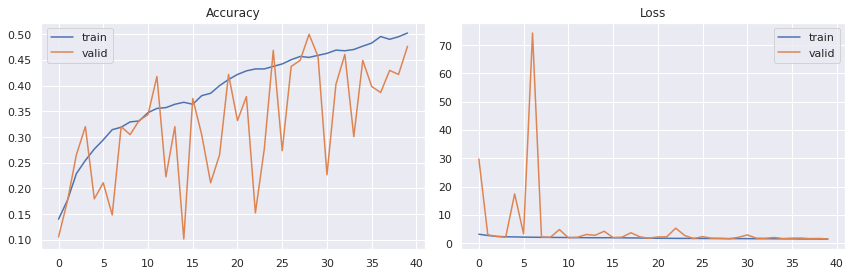

In [16]:
# plot training and validation metrics

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['sparse_categorical_accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_sparse_categorical_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('CNN(500,500)_v2_attempt15.png')

plt.show()

In [ ]:
def make_prediction(path, model, size=(250,250)):
    d = {'path': [path], 'label': [os.path.dirname(path)]}
    df = pd.DataFrame(data=d)
    pred_gen = ImageDataGenerator(rescale=1./255)
    pred_generator = pred_gen.flow_from_dataframe(
        dataframe=df,
        x_col="path",
        y_col="label",
        target_size=size,
        batch_size=1,
        shuffle=False,
        class_mode="sparse",
        seed=42
    )
    res = model.predict(pred_generator)
    return (labelStringArr[np.argmax(res)], res[0][np.argmax(res)])
    

In [ ]:
make_prediction("/mnt/data/data/POL/img_POL_50.114902597259785,21.71049290647834_180.jpg", model)

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,4))
sns.countplot(x='label', data=train_df)

In [ ]:
print("on valid data")
pred1=model.evaluate(X_valid,Y_valid)
print("accuaracy", str(pred1[1]*100))
print("Total loss",str(pred1[0]*100))
